In [27]:
!pip install pydub
import numpy as np
from pydub import AudioSegment
import random
import sys
import io
import os
import glob
import IPython
%matplotlib inline

In [28]:
!cd /content/drive/MyDrive/2020졸업프로젝트/SW알고리즘 음성인식/Trigger-Word-Detection-master

/bin/bash: line 0: cd: too many arguments


In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
import matplotlib.pyplot as plt
from scipy.io import wavfile
import os
from pydub import AudioSegment

# Calculate and plot spectrogram for a wav audio file
def graph_spectrogram(wav_file):
    rate, data = get_wav_info(wav_file)
    nfft = 200 # Length of each window segment
    fs = 8000 # Sampling frequencies
    noverlap = 120 # Overlap between windows
    nchannels = data.ndim
    if nchannels == 1:
        pxx, freqs, bins, im = plt.specgram(data, nfft, fs, noverlap = noverlap)
    elif nchannels == 2:
        pxx, freqs, bins, im = plt.specgram(data[:,0], nfft, fs, noverlap = noverlap)
    return pxx

# Load a wav file
def get_wav_info(wav_file):
    rate, data = wavfile.read(wav_file)
    return rate, data

# Used to standardize volume of audio clip
def match_target_amplitude(sound, target_dBFS):
    change_in_dBFS = target_dBFS - sound.dBFS
    return sound.apply_gain(change_in_dBFS)

# Load raw audio files for speech synthesis
def load_raw_audio():
    activates = []
    backgrounds = []
    negatives = []
    for filename in os.listdir("/content/drive/MyDrive/2020졸업프로젝트/SW알고리즘 음성인식/Trigger-Word-Detection-master/raw_data/activates"):
        if filename.endswith("wav"):
            activate = AudioSegment.from_wav("/content/drive/MyDrive/2020졸업프로젝트/SW알고리즘 음성인식/Trigger-Word-Detection-master/raw_data/activates/"+filename)
            activates.append(activate)
    for filename in os.listdir("/content/drive/MyDrive/2020졸업프로젝트/SW알고리즘 음성인식/Trigger-Word-Detection-master/raw_data/backgrounds"):
        if filename.endswith("wav"):
            background = AudioSegment.from_wav("/content/drive/MyDrive/2020졸업프로젝트/SW알고리즘 음성인식/Trigger-Word-Detection-master/raw_data/backgrounds/"+filename)
            backgrounds.append(background)
    for filename in os.listdir("/content/drive/MyDrive/2020졸업프로젝트/SW알고리즘 음성인식/Trigger-Word-Detection-master/raw_data/negatives"):
        if filename.endswith("wav"):
            negative = AudioSegment.from_wav("/content/drive/MyDrive/2020졸업프로젝트/SW알고리즘 음성인식/Trigger-Word-Detection-master/raw_data/negatives/"+filename)
            negatives.append(negative)
    return activates, negatives, backgrounds

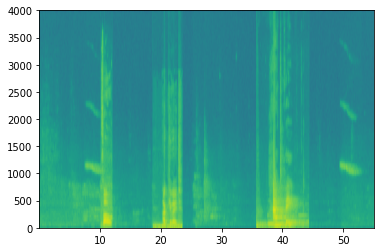

In [31]:
IPython.display.Audio("/content/drive/MyDrive/2020졸업프로젝트/SW알고리즘 음성인식/Trigger-Word-Detection-master/raw_data/activates/1.wav")
x = graph_spectrogram("/content/drive/MyDrive/2020졸업프로젝트/SW알고리즘 음성인식/Trigger-Word-Detection-master/audio_examples/example_train.wav")

In [32]:
_, data = wavfile.read("/content/drive/MyDrive/2020졸업프로젝트/SW알고리즘 음성인식/Trigger-Word-Detection-master/audio_examples/example_train.wav")
print("Time steps in audio recording before spectrogram", data[:,0].shape)
print("Time steps in input after spectrogram", x.shape)
Tx = 5511 # The number of time steps input to the model from the spectrogram
n_freq = 101 # Number of frequencies input to the model at each time step of the spectrogram
Ty = 1375 # The number of time steps in the output of our model

Time steps in audio recording before spectrogram (441000,)
Time steps in input after spectrogram (101, 5511)


In [33]:
activates = []
backgrounds = []
negatives = []
for filename in os.listdir("/content/drive/MyDrive/2020졸업프로젝트/SW알고리즘 음성인식/Trigger-Word-Detection-master/raw_data/activates"):
        if filename.endswith("wav"):
            activate = AudioSegment.from_wav("/content/drive/MyDrive/2020졸업프로젝트/SW알고리즘 음성인식/Trigger-Word-Detection-master/raw_data/activates/"+filename)
            activates.append(activate)
for filename in os.listdir("/content/drive/MyDrive/2020졸업프로젝트/SW알고리즘 음성인식/Trigger-Word-Detection-master/raw_data/backgrounds"):
        if filename.endswith("wav"):
            background = AudioSegment.from_wav("/content/drive/MyDrive/2020졸업프로젝트/SW알고리즘 음성인식/Trigger-Word-Detection-master/raw_data/backgrounds/"+filename)
            backgrounds.append(background)
for filename in os.listdir("/content/drive/MyDrive/2020졸업프로젝트/SW알고리즘 음성인식/Trigger-Word-Detection-master/raw_data/negatives"):
        if filename.endswith("wav"):
            negative = AudioSegment.from_wav("/content/drive/MyDrive/2020졸업프로젝트/SW알고리즘 음성인식/Trigger-Word-Detection-master/raw_data/negatives/"+filename)
            negatives.append(negative)

print("background len: " + str(len(backgrounds[0])))    # Should be 10,000, since it is a 10 sec clip
print("activate[0] len: " + str(len(activates[0])))     # Maybe around 1000, since an "activate" audio clip is usually around 1 sec (but varies a lot)
print("activate[1] len: " + str(len(activates[1])))     # Different "activate" clips can have different lengths 

background len: 10000
activate[0] len: 731
activate[1] len: 1579


In [34]:
def get_random_time_segment(segment_ms):
    """
    Gets a random time segment of duration segment_ms in a 10,000 ms audio clip.
    
    Arguments:
    segment_ms -- the duration of the audio clip in ms ("ms" stands for "milliseconds")
    
    Returns:
    segment_time -- a tuple of (segment_start, segment_end) in ms
    """
    
    segment_start = np.random.randint(low=0, high=10000-segment_ms)   # Make sure segment doesn't run past the 10sec background 
    segment_end = segment_start + segment_ms - 1
    
    return (segment_start, segment_end)

In [35]:
# GRADED FUNCTION: is_overlapping

def is_overlapping(segment_time, previous_segments):
    """
    Checks if the time of a segment overlaps with the times of existing segments.
    
    Arguments:
    segment_time -- a tuple of (segment_start, segment_end) for the new segment
    previous_segments -- a list of tuples of (segment_start, segment_end) for the existing segments
    
    Returns:
    True if the time segment overlaps with any of the existing segments, False otherwise
    """
    
    segment_start, segment_end = segment_time
    
    # Step 1: Initialize overlap as a "False" flag. (≈ 1 line)
    overlap = False
    
    # Step 2: loop over the previous_segments start and end times.
    # Compare start/end times and set the flag to True if there is an overlap (≈ 3 lines)
    for previous_start, previous_end in previous_segments:
        if segment_start <= previous_end and segment_end >= previous_start:
            overlap = True

    return overlap

In [36]:
overlap1 = is_overlapping((950, 1430), [(2000, 2550), (260, 949)])
overlap2 = is_overlapping((2305, 2950), [(824, 1532), (1900, 2305), (3424, 3656)])
print("Overlap 1 = ", overlap1)
print("Overlap 2 = ", overlap2)

Overlap 1 =  False
Overlap 2 =  True


In [37]:
# GRADED FUNCTION: insert_audio_clip

def insert_audio_clip(background, audio_clip, previous_segments):
    """
    Insert a new audio segment over the background noise at a random time step, ensuring that the 
    audio segment does not overlap with existing segments.
    
    Arguments:
    background -- a 10 second background audio recording.  
    audio_clip -- the audio clip to be inserted/overlaid. 
    previous_segments -- times where audio segments have already been placed
    
    Returns:
    new_background -- the updated background audio
    """
    
    # Get the duration of the audio clip in ms
    segment_ms = len(audio_clip)
    
    # Step 1: Use one of the helper functions to pick a random time segment onto which to insert 
    # the new audio clip. (≈ 1 line)
    segment_time = get_random_time_segment(segment_ms)
    
    # Step 2: Check if the new segment_time overlaps with one of the previous_segments. If so, keep 
    # picking new segment_time at random until it doesn't overlap. (≈ 2 lines)
    while is_overlapping(segment_time, previous_segments):
        segment_time = get_random_time_segment(segment_ms)

    # Step 3: Add the new segment_time to the list of previous_segments (≈ 1 line)
    previous_segments.append(segment_time)
    
    # Step 4: Superpose audio segment and background
    new_background = background.overlay(audio_clip, position = segment_time[0])
    
    return new_background, segment_time

In [38]:
np.random.seed(5)
audio_clip, segment_time = insert_audio_clip(backgrounds[0], activates[0], [(3790, 4400)])
audio_clip.export("insert_test.wav", format="wav")
print("Segment Time: ", segment_time)
IPython.display.Audio("insert_test.wav")

Output hidden; open in https://colab.research.google.com to view.

In [39]:
# GRADED FUNCTION: insert_ones

def insert_ones(y, segment_end_ms):
    """
    Update the label vector y. The labels of the 50 output steps strictly after the end of the segment 
    should be set to 1. By strictly we mean that the label of segment_end_y should be 0 while, the
    50 followinf labels should be ones.
    
    
    Arguments:
    y -- numpy array of shape (1, Ty), the labels of the training example
    segment_end_ms -- the end time of the segment in ms
    
    Returns:
    y -- updated labels
    """
    
    # duration of the background (in terms of spectrogram time-steps)
    segment_end_y = int(segment_end_ms * Ty / 10000.0)
    
    # Add 1 to the correct index in the background label (y)
    for i in range(segment_end_y+1, segment_end_y+51):
        if i < Ty:
            y[0, i] = 1.0
    
    return y

sanity checks: 0.0 1.0 0.0


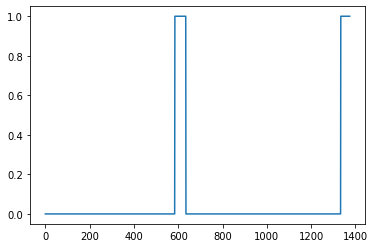

In [40]:
arr1 = insert_ones(np.zeros((1, Ty)), 9700)
plt.plot(insert_ones(arr1, 4251)[0,:])
print("sanity checks:", arr1[0][1333], arr1[0][634], arr1[0][635])

In [41]:
# GRADED FUNCTION: create_training_example

def create_training_example(background, activates, negatives):
    """
    Creates a training example with a given background, activates, and negatives.
    
    Arguments:
    background -- a 10 second background audio recording
    activates -- a list of audio segments of the word "activate"
    negatives -- a list of audio segments of random words that are not "activate"
    
    Returns:
    x -- the spectrogram of the training example
    y -- the label at each time step of the spectrogram
    """
    
    # Set the random seed
    np.random.seed(18)
    
    # Make background quieter
    background = background - 20

    # Step 1: Initialize y (label vector) of zeros (≈ 1 line)
    y = np.zeros((1, Ty))

    # Step 2: Initialize segment times as empty list (≈ 1 line)
    previous_segments = []
    
    # Select 0-4 random "activate" audio clips from the entire list of "activates" recordings
    number_of_activates = np.random.randint(0, 5)
    random_indices = np.random.randint(len(activates), size=number_of_activates)
    random_activates = [activates[i] for i in random_indices]
    
    # Step 3: Loop over randomly selected "activate" clips and insert in background
    for random_activate in random_activates:
        # Insert the audio clip on the background
        background, segment_time = insert_audio_clip(background, random_activate, previous_segments)
        # Retrieve segment_start and segment_end from segment_time
        segment_start, segment_end = segment_time
        # Insert labels in "y"
        y = insert_ones(y, segment_end)
        
    # Select 0-2 random negatives audio recordings from the entire list of "negatives" recordings
    number_of_negatives = np.random.randint(0, 3)
    random_indices = np.random.randint(len(negatives), size=number_of_negatives)
    random_negatives = [negatives[i] for i in random_indices]

    # Step 4: Loop over randomly selected negative clips and insert in background
    for random_negative in random_negatives:
        # Insert the audio clip on the background 
        background, _ = insert_audio_clip(background, random_negative, previous_segments)
    
    # Standardize the volume of the audio clip 
    background = match_target_amplitude(background, -20.0)

    # Export new training example 
    file_handle = background.export("train" + ".wav", format="wav")
    print("File (train.wav) was saved in your directory.")
    
    # Get and plot spectrogram of the new recording (background with superposition of positive and negatives)
    x = graph_spectrogram("train.wav")
    
    return x, y

File (train.wav) was saved in your directory.


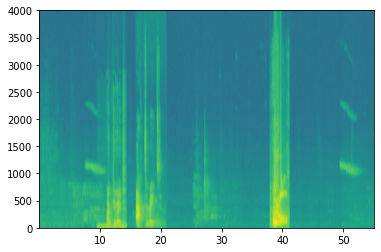

In [42]:
x, y = create_training_example(backgrounds[0], activates, negatives)

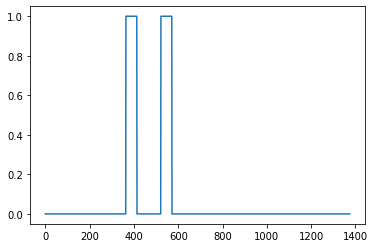

In [43]:
plt.plot(y[0])

In [44]:
from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from keras.optimizers import Adam

# GRADED FUNCTION: model

def model(input_shape):
    """
    Function creating the model's graph in Keras.
    
    Argument:
    input_shape -- shape of the model's input data (using Keras conventions)

    Returns:
    model -- Keras model instance
    """
    
    X_input = Input(shape = input_shape)
        
    # Step 1: CONV layer (≈4 lines)
    X = Conv1D(196, 15, strides=4)(X_input)  # CONV1D
    X = BatchNormalization()(X)              # Batch normalization
    X = Activation('relu')(X)                # ReLu activation

    # Step 2: First GRU Layer (≈4 lines)
    X = GRU(units = 128, return_sequences=True)(X)      # GRU (use 128 units and return the sequences)
    X = Dropout(0.8)(X)                                 # dropout (use 0.8)
    X = BatchNormalization()(X)                         # Batch normalization
    
    # Step 3: Second GRU Layer (≈4 lines)
    X = GRU(units = 128, return_sequences=True)(X)      # GRU (use 128 units and return the sequences)
    X = Dropout(0.8)(X)                                 # dropout (use 0.8)
    X = BatchNormalization()(X)                         # Batch normalization
    X = Dropout(0.8)(X)                                 # dropout (use 0.8)
    
    # Step 4: Time-distributed dense layer (≈1 line)
    X = TimeDistributed(Dense(1, activation = "sigmoid"))(X) # time distributed  (sigmoid)

    model = Model(inputs = X_input, outputs = X)
    
    return model  

model = model(input_shape = (Tx, n_freq))
model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 5511, 101)]       0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 1375, 196)         297136    
_________________________________________________________________
batch_normalization_9 (Batch (None, 1375, 196)         784       
_________________________________________________________________
activation_5 (Activation)    (None, 1375, 196)         0         
_________________________________________________________________
gru_4 (GRU)                  (None, 1375, 128)         125184    
_________________________________________________________________
dropout_6 (Dropout)          (None, 1375, 128)         0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 1375, 128)        

In [45]:
from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from keras.optimizers import Adam

# GRADED FUNCTION: model

def model2(input_shape):
    """
    Function creating the model's graph in Keras.
    
    Argument:
    input_shape -- shape of the model's input data (using Keras conventions)

    Returns:
    model -- Keras model instance
    """
    
    X_input = Input(shape = input_shape)
        
    # Step 1: CONV layer (≈4 lines)
    X = Conv1D(512, 15, strides=4)(X_input)  # CONV1D
    X = BatchNormalization()(X)              # Batch normalization
    X = Activation('relu')(X)                # ReLu activation

    # Step 1: CONV layer (≈4 lines)
    X = Conv1D(256, 15, strides=4)(X_input)  # CONV1D
    X = BatchNormalization()(X)              # Batch normalization
    X = Activation('relu')(X)                # ReLu activation
    
    # Step 1: CONV layer (≈4 lines)
    X = Conv1D(128, 15, strides=4)(X_input)  # CONV1D
    X = BatchNormalization()(X)              # Batch normalization
    X = Activation('relu')(X)                # ReLu activation

        # Step 1: CONV layer (≈4 lines)
    X = Conv1D(64, 15, strides=4)(X_input)  # CONV1D
    X = BatchNormalization()(X)              # Batch normalization
    X = Activation('relu')(X)                # ReLu activation

    # Step 2: First GRU Layer (≈4 lines)
    X = GRU(units = 128, return_sequences=True)(X)      # GRU (use 128 units and return the sequences)
    X = Dropout(0.8)(X)                                 # dropout (use 0.8)
    X = BatchNormalization()(X)                         # Batch normalization
    
    # Step 3: Second GRU Layer (≈4 lines)
    X = GRU(units = 64, return_sequences=True)(X)      # GRU (use 128 units and return the sequences)
    X = Dropout(0.8)(X)                                 # dropout (use 0.8)
    X = BatchNormalization()(X)                         # Batch normalization
    X = Dropout(0.8)(X)                                 # dropout (use 0.8)
    
    # Step 4: Time-distributed dense layer (≈1 line)
    X = TimeDistributed(Dense(1, activation = "sigmoid"))(X) # time distributed  (sigmoid)

    model2 = Model(inputs = X_input, outputs = X)
    
    return model2 

model2 = model2(input_shape = (Tx, n_freq))
model2.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 5511, 101)]       0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 1375, 64)          97024     
_________________________________________________________________
batch_normalization_15 (Batc (None, 1375, 64)          256       
_________________________________________________________________
activation_9 (Activation)    (None, 1375, 64)          0         
_________________________________________________________________
gru_6 (GRU)                  (None, 1375, 128)         74496     
_________________________________________________________________
dropout_9 (Dropout)          (None, 1375, 128)         0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 1375, 128)        

In [46]:
model = load_model('/content/drive/MyDrive/2020졸업프로젝트/SW알고리즘 음성인식/Trigger-Word-Detection-master/models/golumolu_model.h5')
opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])

In [47]:
X= np.load("/content/drive/MyDrive/2020졸업프로젝트/SW알고리즘 음성인식/Trigger-Word-Detection-master/XY_train/X.npy")
Y = np.load("/content/drive/MyDrive/2020졸업프로젝트/SW알고리즘 음성인식/Trigger-Word-Detection-master/XY_train/Y.npy")
X_dev = np.load("/content/drive/MyDrive/2020졸업프로젝트/SW알고리즘 음성인식/Trigger-Word-Detection-master/XY_dev/X_dev.npy")
Y_dev = np.load("/content/drive/MyDrive/2020졸업프로젝트/SW알고리즘 음성인식/Trigger-Word-Detection-master/XY_dev/Y_dev.npy")
model.fit(X, Y, batch_size = 3, epochs=5)

Epoch 1/5
9/9 [==============================] - 53s 6s/step - loss: 0.6270 - accuracy: 0.7066
Epoch 2/5
9/9 [==============================] - 51s 6s/step - loss: 0.6222 - accuracy: 0.7171
Epoch 3/5
9/9 [==============================] - 57s 6s/step - loss: 0.6150 - accuracy: 0.7272
Epoch 4/5
9/9 [==============================] - 52s 6s/step - loss: 0.6092 - accuracy: 0.7500
Epoch 5/5
9/9 [==============================] - 53s 6s/step - loss: 0.6050 - accuracy: 0.7356


In [48]:
model2 = load_model('/content/drive/MyDrive/2020졸업프로젝트/SW알고리즘 음성인식/Trigger-Word-Detection-master/models/golumolu_model.h5')
opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.01)
model2.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])
model2.fit(X, Y, batch_size = 3, epochs=5)
loss, acc = model2.evaluate(X_dev, Y_dev)
print("Dev set accuracy = ", acc)

Epoch 1/5
9/9 [==============================] - 53s 6s/step - loss: 0.6238 - accuracy: 0.7145
Epoch 2/5
9/9 [==============================] - 52s 6s/step - loss: 0.6177 - accuracy: 0.7220
Epoch 3/5
9/9 [==============================] - 52s 6s/step - loss: 0.6167 - accuracy: 0.7294
Epoch 4/5
9/9 [==============================] - 52s 6s/step - loss: 0.6081 - accuracy: 0.7352
Epoch 5/5
1/1 [==============================] - 0s 2ms/step - loss: 0.5433 - accuracy: 0.9269
Dev set accuracy =  0.9268654584884644


In [49]:
loss, acc = model.evaluate(X_dev, Y_dev)
print("Dev set accuracy = ", acc)

1/1 [==============================] - 0s 2ms/step - loss: 0.5697 - accuracy: 0.9270
Dev set accuracy =  0.9270108938217163


In [50]:
def detect_triggerword(filename):
    plt.subplot(2, 1, 1)

    x = graph_spectrogram(filename)
    # the spectogram outputs (freqs, Tx) and we want (Tx, freqs) to input into the model
    x  = x.swapaxes(0,1)
    x = np.expand_dims(x, axis=0)
    predictions = model.predict(x)
    
    plt.subplot(2, 1, 2)
    plt.plot(predictions[0,:,0])
    plt.ylabel('probability')
    plt.show()
    return predictions


chime_file = "/content/drive/MyDrive/2020졸업프로젝트/SW알고리즘 음성인식/Trigger-Word-Detection-master/audio_examples/chime.wav"
def chime_on_activate(filename, predictions, threshold):
    audio_clip = AudioSegment.from_wav(filename)
    chime = AudioSegment.from_wav(chime_file)
    Ty = predictions.shape[1]
    # Step 1: Initialize the number of consecutive output steps to 0
    consecutive_timesteps = 0
    # Step 2: Loop over the output steps in the y
    for i in range(Ty):
        # Step 3: Increment consecutive output steps
        consecutive_timesteps += 1
        # Step 4: If prediction is higher than the threshold and more than 75 consecutive output steps have passed
        if predictions[0,i,0] > threshold and consecutive_timesteps > 75:
            # Step 5: Superpose audio and background using pydub
            audio_clip = audio_clip.overlay(chime, position = ((i / Ty) * audio_clip.duration_seconds)*1000)
            # Step 6: Reset consecutive output steps to 0
            consecutive_timesteps = 0
        
    audio_clip.export("/content/drive/MyDrive/2020졸업프로젝트/SW알고리즘 음성인식/Trigger-Word-Detection-master/chime_output.wav", format='wav')


In [51]:
filename = "/content/drive/MyDrive/2020졸업프로젝트/SW알고리즘 음성인식/Trigger-Word-Detection-master/raw_data/dev/1.wav"
prediction = detect_triggerword(filename)
chime_on_activate(filename, prediction, 0.5)
IPython.display.Audio("/content/drive/MyDrive/2020졸업프로젝트/SW알고리즘 음성인식/Trigger-Word-Detection-master/chime_output.wav")

Output hidden; open in https://colab.research.google.com to view.

In [52]:
filename  = "/content/drive/MyDrive/2020졸업프로젝트/SW알고리즘 음성인식/Trigger-Word-Detection-master/raw_data/dev/2.wav"
prediction = detect_triggerword(filename)
chime_on_activate(filename, prediction, 0.2)
IPython.display.Audio("/content/drive/MyDrive/2020졸업프로젝트/SW알고리즘 음성인식/Trigger-Word-Detection-master/chime_output.wav")

Output hidden; open in https://colab.research.google.com to view.